# Initiate

In [1]:
import time
import os
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine, euclidean

openai.api_key = os.environ['OPENAI_API_KEY']
np.set_printoptions(precision=3, suppress=True)

REFRESH = False

def get_embedding(text, sleep=0):
    '''Compute GPT3-embedding for a given text string'''
    time.sleep(sleep)
    result = openai.Embedding.create(input=text, model='text-embedding-ada-002')
    return np.array(result.data[0].embedding)

messages = pd.read_csv('data/messages.csv', sep='John Cena').content
messages.index = [f'Message_{i}' for i in messages.index]
images = pd.read_csv('data/images.csv', sep='John Cena').content
images.index = [f'Image_{i}' for i in images.index]

C:\Users\Ansebi\AppData\Local\Temp\ipykernel_15096\2031779876.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  messages = pd.read_csv('data/messages.csv', sep='John Cena').content
C:\Users\Ansebi\AppData\Local\Temp\ipykernel_15096\2031779876.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  images = pd.read_csv('data/images.csv', sep='John Cena').content


# Get Embedding Dataframes

In [2]:
def glue(row):
    replacement_dict = {'Male': 'man', 'Female': 'woman'}
    row['Gender'] = replacement_dict.get(row['Gender'], 'John Cena')
    return ' '.join(row[['Lifestyle', 'Age', 'Race', 'Gender']].values).lower()

In [3]:
path_test_vector = 'data/embeddings/test_vector'
if REFRESH:
    test_vector = get_embedding('test')
    np.save(path_test_vector, test_vector)
else:
    test_vector = np.load(
        f'{path_test_vector}.npy',
        allow_pickle=True
    )

In [4]:
df_people = pd.read_csv('./data/people.csv')
people = {}
person_id = 0
for person in list(df_people.items())[0][1]:
    person = person.replace('\r', '')
    person_list = [i.split(': ') for i in person.split('\n')]
    person_dict = {j[0]: j[1] for j in person_list}
    people[f'Person_{person_id}'] = person_dict
    person_id += 1
df_people = pd.DataFrame(people).T
df_people['Likes'] = df_people['Likes'].str.split(', ')
df_people['Dislikes'] = df_people['Dislikes'].str.split(', ')
df_people['Description'] = df_people.apply(
    lambda row: glue(row), axis='columns')
# df_people['Person_ID'] = df_people.index
df_people.head(1)

,Gender,Age,Race,Lifestyle,Likes,Dislikes,Description
Person_0,man,Young Adult,African American,Moderate,"[Sports, Outdoors, Learning, Exercise]","[Homemaking, Design, Relaxing, Arts and Crafts]",moderate young adult african american man


In [5]:
path_activities = 'data/embeddings/activities_embeddings.csv'
if REFRESH:
    activities = []
    for person in people.values():
        for attitude in ['Likes', 'Dislikes']:
            for activity in person[attitude].split(', '):
                if activity not in activities:
                    activities.append(activity)
    activities.sort()
    activities = {activity: get_embedding(activity) for activity in activities}
    df_activities = pd.DataFrame(activities)
    df_activities.to_csv(path_activities, index=False)
else:
    df_activities = pd.read_csv(path_activities)


In [6]:
def prepare(df):
    """
    center and normalize each point of the vector from -1 to 1
    compared to the neighbouring entities.
    Each feature inside of 1536 long-vector is normalized separately
    according to the observations of the same feature in other entities.
    """
    df_ = df.copy()
    mean = df_.mean(axis='columns')
    df_ = df_.apply(lambda column: column - mean, axis='rows')
    min_ = df_.apply(lambda row: row.min(), axis='columns')
    max_ = df_.apply(lambda row: row.max(), axis='columns')
    df_ = df_.apply(
        lambda column: 2 * (column - min_) / (max_ - min_) - 1,
        axis='rows'
    )
    return df_

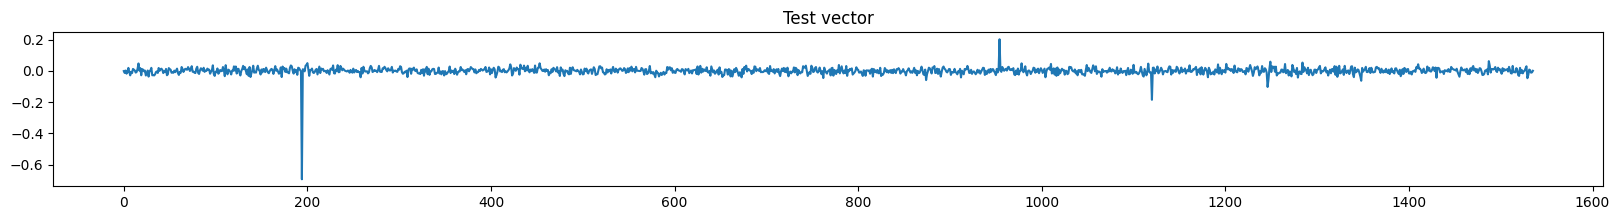

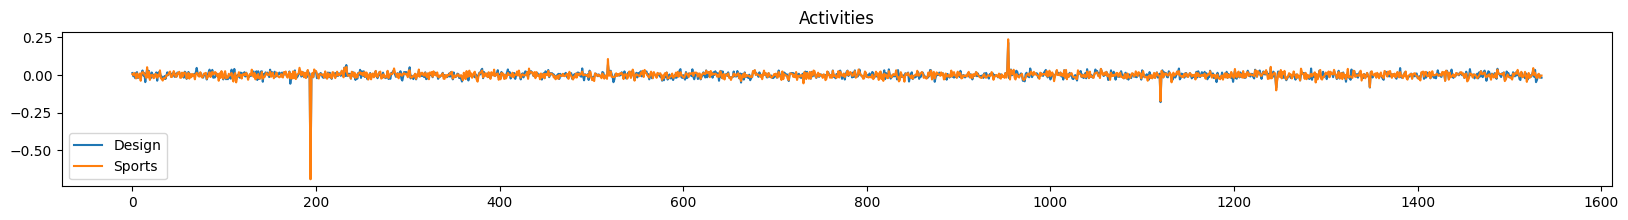

In [7]:
plt.figure(figsize=(20,2))
plt.plot(test_vector)
plt.title('Test vector')
plt.show()
plt.figure(figsize=(20,2))
plt.title('Activities')
# for activity in activities:
#     plt.plot(df_activities[activity], label=activity)
plt.plot(df_activities['Design'], label='Design')
plt.plot(df_activities['Sports'], label='Sports')
plt.legend()
plt.show()

In [8]:
df_activities = prepare(df_activities)

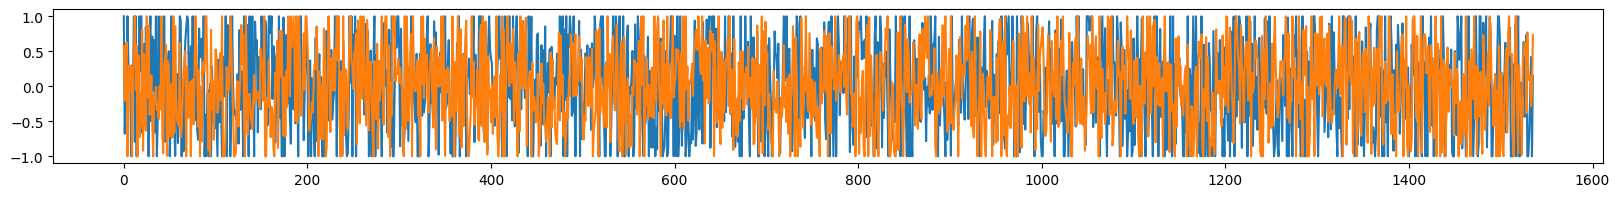

In [9]:
plt.figure(figsize=(20,2))
# for activity in activities:
#     plt.plot(df_activities[activity])
plt.plot(df_activities['Design'])
plt.plot(df_activities['Sports'])

In [10]:
path_people_descriptions = 'data/embeddings/people_descriptions_embeddings.csv'
if REFRESH:
    people_descriptions = {id: get_embedding(description) for id, description in zip(df_people.Person_ID, df_people.Description)}
    df_people_descriptions = pd.DataFrame(people_descriptions)
    df_people_descriptions.to_csv(path_people_descriptions, index=False)
else:
    df_people_descriptions = pd.read_csv(path_people_descriptions)


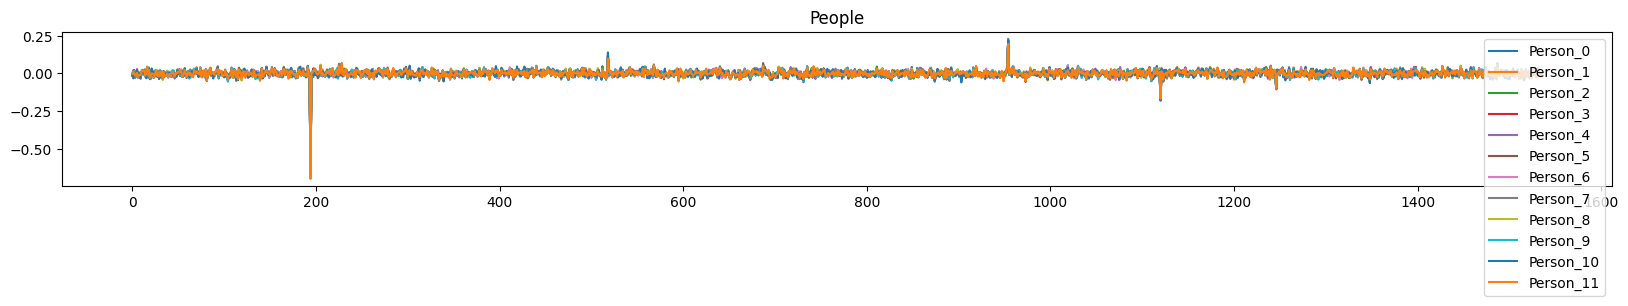

In [11]:
plt.figure(figsize=(20,2))
plt.title('People')
for person in people:
    plt.plot(df_people_descriptions[person], label=person)
plt.legend()
plt.show()

In [12]:
df_people_descriptions = prepare(df_people_descriptions)

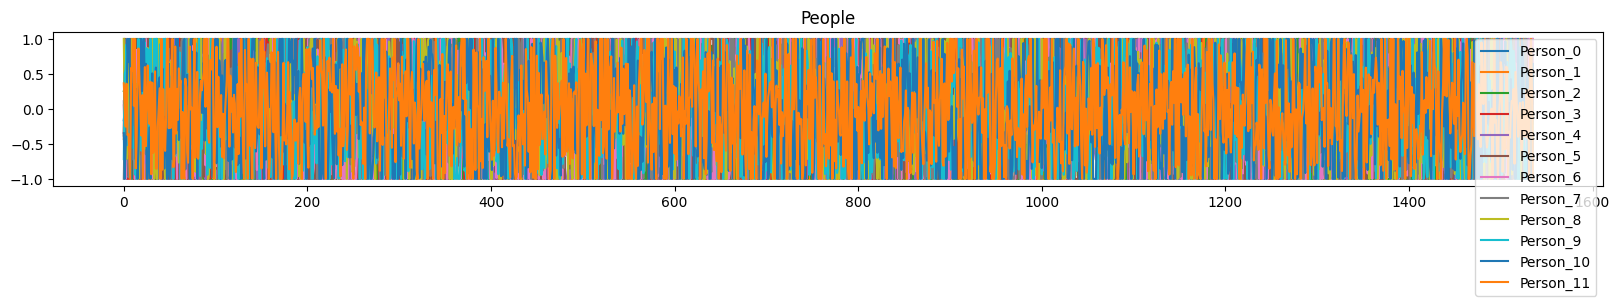

In [13]:
plt.figure(figsize=(20,2))
plt.title('People')
for person in people:
    plt.plot(df_people_descriptions[person], label=person)
plt.legend()
plt.show()

In [14]:
path_messages = 'data/embeddings/messages'
df_messages = pd.DataFrame(
    list(
        np.load(
            f'{path_messages}.npy',
            allow_pickle=True
        )
    )
).T
df_messages.columns = [f'Message_{i}' for i in df_messages.columns]

In [15]:
df_messages = prepare(df_messages)

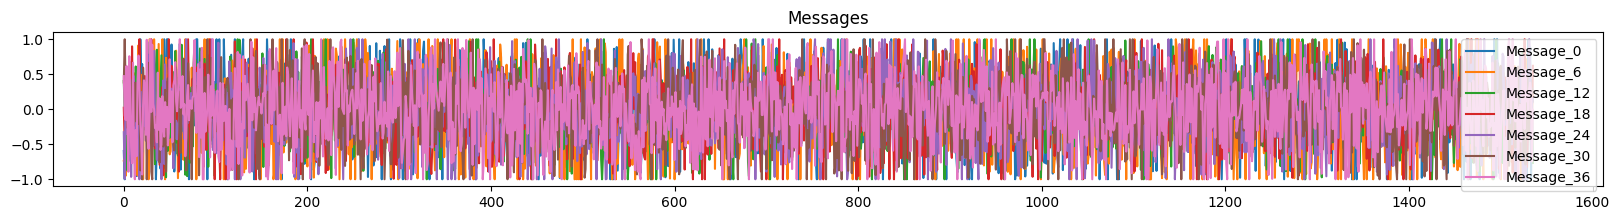

In [16]:
plt.figure(figsize=(20,2))
plt.title('Messages')
for message_id in df_messages.columns[::6]:
    plt.plot(df_messages[message_id], label=message_id)
plt.legend()
plt.show()

In [17]:
path_images = 'data/embeddings/images'
df_images = pd.DataFrame(
    list(
        np.load(
            f'{path_images}.npy',
            allow_pickle=True
        )
    )
).T
df_images.columns = [f'Image_{i}' for i in df_images.columns]

In [18]:
df_images = prepare(df_images)

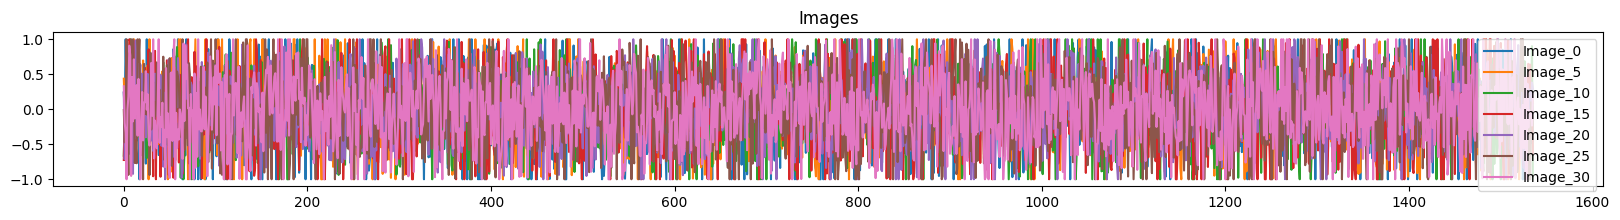

In [19]:
plt.figure(figsize=(20,2))
plt.title('Images')
for image_id in df_images.columns[::5]:
    plt.plot(df_images[image_id], label=image_id)
plt.legend()
plt.show()

# Get Distances

In [20]:
def get_cosine(vec_1, vec_2, epsilon=10**-6):
    """
    cosine() is so bad, that it's incapable
    of evaluating [0, 0] to [1, 1] distance
    due to zero division.
    Thus we manually bring it to live here
    """
    vec_1 = [i if i else epsilon for i in vec_1]
    vec_2 = [i if i else epsilon for i in vec_2]
    return cosine(vec_1, vec_2)

    
def ansnorm(vec_1, vec_2):
    """
    intended to work with -1 to 1 normalized vectors
    combines two approaches so that negatives of cosine similarity
    are smoothened as well as the negatives of euclidean alone
    """
    euc = euclidean(vec_1, vec_2)
    cos = get_cosine(vec_1, vec_2)
    # let's scale both distances to [0, 1]
    # since cosine() lies between 0 and 2, halve it    
    cos /= 2
    # now normalize the euclidean distance output
    # larges distances in our case are beteween
    # [-1, -1, ... , -1] and [1, 1, ... , 1]
    # and the value depends on n dimensions
    # so let's consider it
    ones = np.ones(len(vec_1))
    largest_euc = euclidean(-ones, ones)
    euc /= largest_euc    
    dist = euc/2 + euc*cos + cos/2
    # scale dist to [0, 1]
    dist /= 2
    # return euc, cos, dist  # an option for testing the function
    return dist

In [21]:
distances = {
    'activity-image': {},
    'activity-message': {},
    'person-image': {},
    'person-message': {},
    'image-message': {}
}

In [22]:
for activity in df_activities.columns:
    distances['activity-image'][activity] = {}
    distances['activity-message'][activity] = {}
    for image_id in df_images.columns:
        distances['activity-image'][activity][image_id] = ansnorm(df_activities[activity], df_images[image_id])
    for message_id in df_messages.columns:
        distances['activity-message'][activity][message_id] = ansnorm(df_activities[activity], df_messages[message_id])


In [23]:
df = prepare(pd.DataFrame(distances['activity-image']).T).T
df.index = images
df.style.background_gradient(cmap='YlGnBu')

,Arts and Crafts,Design,Exercise,Games,Homemaking,Indoors,Learning,Outdoors,Relaxing,Sports
content,,,,,,,,,,
Young adult Indian man playing guitar and smiling.,0.221023,0.425324,1.000000,-0.025090,0.711817,0.308647,-0.299681,0.629021,-0.246441,-0.208810
Adult white woman rolling dough in the kitchen and smiling.,0.311137,0.702886,0.419051,0.518617,-0.345202,0.520108,-0.012946,0.708203,-0.292476,0.551905
Person with glasses filling out the newspaper crossword puzzle.,-0.095837,0.031670,0.022534,0.017897,0.712657,0.626734,0.018052,0.349739,0.537890,-0.324350
Senior hispanic man playing a game of cards in the park.,0.606040,0.342834,-0.053671,-1.000000,0.527211,0.756189,0.288511,0.212776,0.403285,-1.000000
Young adult asian woman reading a book outside and smiling.,0.466371,0.365641,0.579830,0.588754,0.749595,-0.110262,-1.000000,-0.720628,-0.284751,-0.021689
Person coloring in a coloring book with crayons.,-1.000000,-0.323870,0.282842,0.039786,0.610946,0.732323,-0.034810,0.843253,0.081700,-0.048310
Senior white woman biking in the park and looking towards the sky.,0.419034,0.177473,-1.000000,0.450237,0.627089,0.613467,0.216453,-0.599583,-0.353173,-0.258973
Person knitting at home next to a basket of yarn.,-0.851911,0.560169,0.781561,0.952699,-0.053019,0.489226,1.000000,0.815452,0.482203,0.675040
Young adult African American man walking his dog in the park.,0.615005,-0.171069,-0.632466,0.132378,0.812181,0.664939,0.279651,-0.490527,0.316903,-0.258425


In [24]:
df = prepare(pd.DataFrame(distances['activity-message']).T).T
# df = pd.DataFrame(distances['activity-image'])
df.index = pd.read_csv('data/messages.csv', sep='John Cena').content
df.style.background_gradient(cmap='YlGnBu')

C:\Users\Ansebi\AppData\Local\Temp\ipykernel_15096\4198677070.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df.index = pd.read_csv('data/messages.csv', sep='John Cena').content


,Arts and Crafts,Design,Exercise,Games,Homemaking,Indoors,Learning,Outdoors,Relaxing,Sports
content,,,,,,,,,,
"Put on your favorite tunes and dance like nobody's watching! It's a fun way to get moving, express yourself, and let loose. Plus, you might just discover some new dance moves!",0.258010,0.734462,-0.414091,0.356184,0.898348,0.309773,0.321056,0.718456,0.120867,-0.056714
"Take a break from your screen and hit the trails! Hiking is a great way to explore nature, get some exercise, and clear your mind. Don't forget to bring some snacks and water!",0.712720,0.261444,-0.332052,0.350103,0.949087,0.016101,0.921902,-0.923750,0.036073,-0.361680
"Unroll your yoga mat and take a deep breath. Yoga is a great way to stretch your body, calm your mind, and improve your overall well-being. Namaste!",0.750132,0.909932,-0.350219,0.899083,0.848554,-0.343230,0.626257,0.730420,-0.802687,0.432334
"Hop on your bike and feel the wind in your hair! Biking is a fun and eco-friendly way to explore your surroundings, get some exercise, and enjoy the outdoors. Don't forget your helmet!",0.700747,0.349809,-0.056830,0.649781,0.523299,-0.651526,0.551970,-0.644963,0.526604,-0.090996
"Step away from your screen and take a walk outside. Walking is a simple and accessible way to get some exercise, clear your mind, and enjoy the fresh air. Take a different route and see where it takes you!",0.836464,0.329874,-0.909595,0.234434,1.000000,-1.000000,0.668579,-0.925175,-0.218050,-0.081117
"Dive into the pool and make a splash! Swimming is a great way to cool off, get a full-body workout, and have fun in the water. Don't forget your sunscreen!",0.928149,0.347008,-0.253088,0.616673,0.880400,-0.251478,0.792780,0.243955,0.169788,-0.755532
"Pick up some weights and feel the burn! Weightlifting is a great way to build muscle, boost your metabolism, and feel more confident in your body. You got this!",1.000000,0.307382,-0.818377,0.621316,0.540344,0.240566,0.158701,0.674882,0.534011,0.261130
"Put on your running shoes and hit the pavement! Jogging is a great way to improve your cardiovascular health, burn calories, and reduce stress. Start slow and steady, and work your way up!",0.876529,0.434478,-1.000000,0.579498,0.323406,-0.297340,0.500933,0.350146,0.179248,-0.300818
"Strap on your roller skates and roll into some fun! Roller skating is a great way to improve your balance, coordination, and get a great workout for your legs and core. Don't forget your knee pads!",0.580930,0.483121,-0.376702,0.299731,0.981997,-0.300573,0.537754,0.324151,0.502492,-0.712163


In [25]:
for person_id in df_people_descriptions.columns:
    distances['person-image'][person_id] = {}
    distances['person-message'][person_id] = {}
    for image_id in df_images.columns:
        distances['person-image'][person_id][image_id] = ansnorm(df_people_descriptions[person_id], df_images[image_id])
    for message_id in df_messages.columns:
        distances['person-message'][person_id][message_id] = ansnorm(df_people_descriptions[person_id], df_messages[message_id])

In [26]:
df = prepare(pd.DataFrame(distances['person-image']).T).T
df.columns = df_people.Description
df.index = images
df.style.background_gradient(cmap='YlGnBu')

Description,moderate young adult african american man,active adult asian woman,sedentary senior hispanic man,moderate young adult asian woman,active adult white man,sedentary middle-aged hispanic woman,moderate senior white man,active young adult asian woman,sedentary adult african american man,moderate middle-aged asian woman,active senior african american man,sedentary young adult white woman
content,,,,,,,,,,,,
Young adult Indian man playing guitar and smiling.,-0.210535,0.355539,0.388620,-0.101095,-0.005291,0.789742,0.331241,-0.102689,0.254825,0.391642,0.279802,0.287465
Adult white woman rolling dough in the kitchen and smiling.,0.649312,-0.013224,0.739266,0.008148,-0.137354,-0.244730,0.085527,0.136985,0.786777,-0.195219,0.588168,-0.623202
Person with glasses filling out the newspaper crossword puzzle.,0.229287,0.497847,0.150828,0.177541,0.450327,-0.353700,0.199670,0.462667,0.186382,0.022408,0.181785,0.039734
Senior hispanic man playing a game of cards in the park.,0.394176,1.000000,-1.000000,0.885907,0.479907,-1.000000,-0.155356,1.000000,0.342972,0.780727,-0.507627,1.000000
Young adult asian woman reading a book outside and smiling.,0.552642,-1.000000,0.894957,-0.975121,0.421814,0.252621,0.873116,-0.995503,1.000000,-0.863311,0.852031,-0.164707
Person coloring in a coloring book with crayons.,0.170507,0.347417,0.293545,0.079743,0.161599,-0.181805,0.336978,0.301106,-0.008599,0.037186,0.365112,-0.206755
Senior white woman biking in the park and looking towards the sky.,1.000000,0.018760,0.231954,0.359074,0.419070,-0.427560,-0.045837,0.243363,0.679594,-0.165153,-0.502731,-0.277091
Person knitting at home next to a basket of yarn.,0.468039,0.259928,0.408131,0.013766,0.809743,-0.391273,0.692875,0.282769,0.252241,-0.272236,0.586135,-0.135453
Young adult African American man walking his dog in the park.,-1.000000,0.994083,0.363601,0.596543,0.229786,1.000000,0.405313,0.661502,-1.000000,1.000000,-0.762663,0.466206


In [27]:
df = prepare(pd.DataFrame(distances['person-message']).T).T
df.columns = df_people.Description
df.index = messages
df.style.background_gradient(cmap='YlGnBu')

Description,moderate young adult african american man,active adult asian woman,sedentary senior hispanic man,moderate young adult asian woman,active adult white man,sedentary middle-aged hispanic woman,moderate senior white man,active young adult asian woman,sedentary adult african american man,moderate middle-aged asian woman,active senior african american man,sedentary young adult white woman
content,,,,,,,,,,,,
"Put on your favorite tunes and dance like nobody's watching! It's a fun way to get moving, express yourself, and let loose. Plus, you might just discover some new dance moves!",-0.284428,0.142305,0.149034,0.125167,0.864119,-0.026913,0.901040,-0.232966,-0.145469,0.670915,0.110905,-0.321308
"Take a break from your screen and hit the trails! Hiking is a great way to explore nature, get some exercise, and clear your mind. Don't forget to bring some snacks and water!",-0.140218,-0.333663,-0.673666,0.197352,-0.516058,-0.645716,0.181537,-0.117152,-0.577748,0.310205,-0.242860,-0.291972
"Unroll your yoga mat and take a deep breath. Yoga is a great way to stretch your body, calm your mind, and improve your overall well-being. Namaste!",1.000000,-0.636207,0.093162,-0.760849,0.828441,-0.161925,0.447413,-0.591608,0.487074,-1.000000,0.631935,0.000190
"Hop on your bike and feel the wind in your hair! Biking is a fun and eco-friendly way to explore your surroundings, get some exercise, and enjoy the outdoors. Don't forget your helmet!",0.446462,-0.251470,-0.315162,-0.302621,-0.323575,0.069610,0.390051,-0.537789,0.072546,0.308888,0.195496,-0.505251
"Step away from your screen and take a walk outside. Walking is a simple and accessible way to get some exercise, clear your mind, and enjoy the fresh air. Take a different route and see where it takes you!",-0.701253,0.168541,-0.161636,0.355411,-0.889458,0.009148,-0.479398,0.482116,-0.577476,0.118321,-0.598065,-0.271364
"Dive into the pool and make a splash! Swimming is a great way to cool off, get a full-body workout, and have fun in the water. Don't forget your sunscreen!",-0.394666,-0.522832,0.050074,-0.197693,-0.261627,0.333724,0.479875,-0.440153,-0.076641,0.419960,-0.079648,0.198372
"Pick up some weights and feel the burn! Weightlifting is a great way to build muscle, boost your metabolism, and feel more confident in your body. You got this!",-0.062197,0.225131,0.941260,1.000000,-0.834249,0.601913,0.145509,0.153551,-0.001666,0.554047,0.143542,-0.026019
"Put on your running shoes and hit the pavement! Jogging is a great way to improve your cardiovascular health, burn calories, and reduce stress. Start slow and steady, and work your way up!",-1.000000,1.000000,0.130580,0.009314,0.829265,-0.114976,0.141762,0.649346,-0.016470,0.033489,-0.095267,-0.018736
"Strap on your roller skates and roll into some fun! Roller skating is a great way to improve your balance, coordination, and get a great workout for your legs and core. Don't forget your knee pads!",-0.113659,0.368239,-0.157329,0.153572,0.480933,0.192700,0.616526,-0.150518,-0.278288,1.000000,0.067071,-0.203751


In [28]:
for image_id in df_images.columns:
    distances['image-message'][image_id] = {}
    for message_id in df_messages.columns:
        distances['image-message'][image_id][message_id] = ansnorm(df_images[image_id], df_messages[message_id])

In [29]:
df = prepare(pd.DataFrame(distances['image-message']).T).T
df.columns = images
df.index = messages
df.style.background_gradient(cmap='YlGnBu')

content,Young adult Indian man playing guitar and smiling.,Adult white woman rolling dough in the kitchen and smiling.,Person with glasses filling out the newspaper crossword puzzle.,Senior hispanic man playing a game of cards in the park.,Young adult asian woman reading a book outside and smiling.,Person coloring in a coloring book with crayons.,Senior white woman biking in the park and looking towards the sky.,Person knitting at home next to a basket of yarn.,Young adult African American man walking his dog in the park.,Person shuffling a deck of playing cards.,Young adult woman making heart hands outdoors at sunset.,Young adult asian woman in orange vest looking up at a dynamic sky.,Young adult hispanic man taking a deep breath outdoors.,Young adult asian woman meditating outdoors.,"Young adult African American woman listening to music, smiling, and fist pumping.",Woman dancing with her dog at home.,Young adult white woman dancing and cleaning the house.,Man holding wooden stick while drilling hole.,"A wooden desk with ink pens, books, and a notebook with handwriting practice.",Person sketching flowers in a notepad.,Senior white man painting flowers on a canvas.,Adult white man reading a book while sitting in the sea.,Adult asian man focusing on something indoors.,Middle-aged white woman drinking water at the table and looking down at something.,Senior man planting seeds outside.,Woman placing a cutting board into the kitchen cupboard.,"Flatly with a notebook, coffee, glasses, and polaroids.",Young adult African American woman looking at the newspaper.,Young adult asian woman placing a blanket on the sofa.,Senior white man wearing a coat and holding a book while walking outdoors.,Adult African American man reading a book to his baby.,Senior Italian woman raising her arms and celebrating outdoors.,Adult white woman sitting at a desk and painting.,Middle-aged African American woman picking apples in a garden.
content,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Put on your favorite tunes and dance like nobody's watching! It's a fun way to get moving, express yourself, and let loose. Plus, you might just discover some new dance moves!",-0.272949,0.377056,1.000000,0.284678,0.916522,0.620014,0.320928,0.854631,-0.043944,0.052641,0.140366,0.098206,0.591657,0.569009,-1.000000,-1.000000,-0.958049,0.956385,1.000000,0.675480,0.451662,1.000000,0.583276,0.468981,1.000000,0.868344,0.699544,0.407710,0.187514,0.723316,0.828308,-1.000000,0.357241,0.709492
"Take a break from your screen and hit the trails! Hiking is a great way to explore nature, get some exercise, and clear your mind. Don't forget to bring some snacks and water!",0.636567,0.793615,0.449820,-0.201999,0.074106,0.743327,-0.651741,0.867999,-0.691257,0.636874,-0.653005,-0.018182,-0.604535,-0.292501,0.599228,0.474343,0.945151,0.156355,0.315096,0.198248,0.351563,-0.044149,0.788394,-0.925895,-0.090785,0.693968,-0.511794,0.286410,0.627959,-0.514514,0.760952,0.095544,0.382941,0.030222
"Unroll your yoga mat and take a deep breath. Yoga is a great way to stretch your body, calm your mind, and improve your overall well-being. Namaste!",0.060123,0.560440,0.914342,0.673300,0.450272,0.932743,0.176111,0.575921,0.359769,0.446329,0.509622,-0.480457,-0.734010,-0.858811,0.524416,0.098018,0.730385,0.597355,0.530112,0.414843,0.831620,0.402872,0.448332,0.288046,0.530907,0.899556,0.619077,0.694724,-0.499532,0.614636,0.862599,-0.103689,0.727274,1.000000
"Hop on your bike and feel the wind in your hair! Biking is a fun and eco-friendly way to explore your surroundings, get some exercise, and enjoy the outdoors. Don't forget your helmet!",-0.092567,0.565429,0.674222,0.374652,-0.077341,0.949713,-1.000000,0.798559,-0.379965,0.860570,-0.239207,-0.889856,-0.276492,0.159922,0.470329,0.294288,0.592387,0.746330,0.663903,0.592862,0.686363,0.204637,0.656691,0.697171,0.206111,0.918297,0.238551,0.233773,0.734052,-0.181354,0.845326,-0.491559,0.651027,0.574736
"Step away from your screen and take a walk outside. Walking is 

In [31]:
# # V2 demography-focused
# 1/0
# images_for_people = {}
# for person_id in df_people.index:
#     images_for_people[person_id] = {}
#     person_dislikes = df_people.loc[person_id]['Dislikes']
#     person_likes = df_people.loc[person_id]['Likes']
#     for image_id in df_images:
#         demography_distance = distances['person-image'][person_id][image_id]
#         shortest_dislike_distance = None
#         for dislike in person_dislikes:
#             dislike_distance = distances['activity-image'][dislike][image_id]
#             if shortest_dislike_distance is None:
#                 shortest_dislike_distance = dislike_distance
#             else:
#                 if dislike_distance < shortest_dislike_distance:
#                     shortest_dislike_distance = dislike_distance
#             shortest_dislike_distance = dislike_distance 
#         mean_like_distance = 0
#         for like in person_likes:
#             like_distance = distances['activity-image'][like][image_id]
#             mean_like_distance += like_distance
#         mean_like_distance /= len(person_likes)
#         personal_benchmark = demography_distance + mean_like_distance - shortest_dislike_distance
#         images_for_people[person_id][image_id] = personal_benchmark
# df_images_for_people = pd.DataFrame(images_for_people)
# 1/0

In [32]:
# V1 preferences accent
images_for_people = {}
for person_id in df_people.index:
    images_for_people[person_id] = {}
    person_dislikes = df_people.loc[person_id]['Dislikes']
    person_likes = df_people.loc[person_id]['Likes']
    for image_id in df_images:
        demography_distance = distances['person-image'][person_id][image_id]
        cummulative_dislike_distance = 0
        for dislike in person_dislikes:
            dislike_distance = distances['activity-image'][dislike][image_id]
            cummulative_dislike_distance += dislike_distance
        cummulative_like_distance = 0
        for like in person_likes:
            like_distance = distances['activity-image'][like][image_id]
            cummulative_like_distance += like_distance
        personal_benchmark = demography_distance + cummulative_like_distance - cummulative_dislike_distance
        images_for_people[person_id][image_id] = personal_benchmark
df_images_for_people = pd.DataFrame(images_for_people)

In [33]:
df = prepare(df_images_for_people.T).T
df.columns = df_people.Description + '\nDISLIKES\n' + df_people.Dislikes.apply(lambda x: '\n'.join(x)) + '\nLIKES\n' + df_people.Likes.apply(lambda x: '\n'.join(x))
df.index = images
df.style.background_gradient(cmap='YlGnBu')

,moderate young adult african american man DISLIKES Homemaking Design Relaxing Arts and Crafts LIKES Sports Outdoors Learning Exercise,active adult asian woman DISLIKES Arts and Crafts Design Games Relaxing LIKES Outdoors Exercise Sports Homemaking,sedentary senior hispanic man DISLIKES Outdoors Sports Exercise Design LIKES Relaxing Homemaking Indoors Arts and Crafts,moderate young adult asian woman DISLIKES Sports Outdoors Homemaking Relaxing LIKES Learning Design Arts and Crafts Games,active adult white man DISLIKES Homemaking Design Arts and Crafts Relaxing LIKES Sports Outdoors Exercise Games,sedentary middle-aged hispanic woman DISLIKES Outdoors Sports Exercise Design LIKES Relaxing Homemaking Indoors Arts and Crafts,moderate senior white man DISLIKES Sports Outdoors Homemaking Exercise LIKES Learning Design Arts and Crafts Relaxing,active young adult asian woman DISLIKES Arts and Crafts Design Games Relaxing LIKES Sports Outdoors Exercise Homemaking,sedentary adult african american man DISLIKES Outdoors Sports Exercise Design LIKES Relaxing Homemaking Indoors Arts and Crafts,moderate middle-aged asian woman DISLIKES Sports Outdoors Homemaking Relaxing LIKES Learning Design Arts and Crafts Games,active senior african american man DISLIKES Homemaking Design Arts and Crafts Relaxing LIKES Sports Outdoors Exercise Games,sedentary young adult white woman DISLIKES Outdoors Sports Exercise Homemaking LIKES Relaxing Arts and Crafts Design Games
content,,,,,,,,,,,,
Young adult Indian man playing guitar and smiling.,-0.158269,0.468172,-0.190149,-0.369927,-0.253979,-0.054868,-0.170557,0.233158,-0.177747,-0.142518,0.105694,-0.185945
Adult white woman rolling dough in the kitchen and smiling.,0.584521,-0.205733,-0.455492,0.115654,0.251261,-0.823569,0.098700,-0.058531,-0.439635,-0.025977,0.723736,-0.248822
Person with glasses filling out the newspaper crossword puzzle.,-0.129024,0.275712,0.230426,-0.398512,-0.296437,0.042049,0.095007,0.323017,0.415919,-0.504764,-0.157157,-0.053778
Senior hispanic man playing a game of cards in the park.,-0.327974,0.274228,-0.263192,0.412474,-0.928992,0.094337,0.514163,0.381212,0.854531,0.181983,-1.000000,0.795997
Young adult asian woman reading a book outside and smiling.,-0.258381,-0.891108,0.543802,-0.520244,-0.375052,0.066877,0.514972,-0.875120,0.624253,-0.345132,0.061335,0.139283
Person coloring in a coloring book with crayons.,0.417608,0.868084,-0.277534,-0.843169,0.338928,-0.397264,-0.584886,0.868308,-0.341743,-0.854351,0.586219,-0.881293
Senior white woman biking in the park and looking towards the sky.,-0.015226,-0.489830,0.567345,0.496567,-0.537362,0.244331,0.410034,-0.280267,0.982117,0.135080,-0.633923,0.257387
Person knitting at home next to a basket of yarn.,0.772722,0.254828,-0.848835,-0.345087,1.000000,-1.000000,0.181784,0.321205,-0.897322,-0.494201,0.985148,-0.271935
Young adult African American man walking his dog in the park.,-1.000000,0.134722,1.000000,0.320031,-0.848034,1.000000,0.699250,0.041904,0.428816,0.368503,-0.932463,0.622853


In [67]:
def string2paragraph(string, width):
    list_ = string.split(' ')
    current_word_number = 0
    paragraph = ''
    while True:
        finished_a_line = False
        line = ''
        while not finished_a_line:
            word = list_[current_word_number]
            if line:
                word = ' ' + word
            line += word
            if len(line) >= width:
                finished_a_line = True
            current_word_number += 1
            if current_word_number == len(list_):
                return paragraph + line
        if current_word_number == len(list_):
            return paragraph + line
        paragraph += line + '\n'

In [71]:
TOP_N = 3
for person_id in df_images_for_people:
    print('\n'*3)
    print(df_people.loc[person_id].Description)
    print('Likes:', ' '.join(df_people.loc[person_id].Likes))
    print('Dislikes:', ' '.join(df_people.loc[person_id].Dislikes))
    personal_top_images = df_images_for_people[person_id].sort_values()[:TOP_N].index
    for n, image_id in enumerate(personal_top_images):
        print()
        print(n, end='. ')
        print(images.loc[image_id])
        best_message_id = sorted(distances['image-message'][image_id].items(), key=lambda x: [x[1]])[0][0]
        print('Message:')
        print(string2paragraph(messages.loc[best_message_id], 60))





moderate young adult african american man
Likes: Sports Outdoors Learning Exercise
Dislikes: Homemaking Design Relaxing Arts and Crafts

0. Young adult African American man walking his dog in the park.
Message:
Step away from your screen and take a walk outside. Walking is
a simple and accessible way to get some exercise, clear your
mind, and enjoy the fresh air. Take a different route and see
where it takes you!

1. Young adult African American woman looking at the newspaper.
Message:
Take a break from your screen and dive into a good book. Reading
can transport you to new worlds and expand your knowledge. Who
knows what you might discover?

2. Young adult hispanic man taking a deep breath outdoors.
Message:
Take a break from your screen and focus on your breath. Meditating
can reduce stress, improve focus, and promote overall well-being.
Find a quiet spot and give it a try!




active adult asian woman
Likes: Outdoors Exercise Sports Homemaking
Dislikes: Arts and Crafts Design Ga